In [1]:
# A DNN is trained on the function y = cos(x) and the process of optimizing weights is shown. 

import numpy as np
import torch
import torchvision as tv
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\anoop\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Create random data between (-10, 10) and determine groundtruth
simulatedInput = 3*torch.rand(1000,1)
groundTruth = torch.sin(5*math.pi*simulatedInput)

In [3]:
# Calculate the number of parameters in a neural network
def calcParams(inputModel):
    val = sum(params.numel() for params in inputModel.parameters() if params.requires_grad)
    return val

In [4]:
calcParams(nn.Linear(10,20))

220

In [5]:
# Set up NN for cos(x) training - 2 Hidden Layers, 32 parameters 
class OptimizeNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [6]:
# Set up necessary auxilaries for neural net training
optimNet = OptimizeNN()
costFunc = nn.MSELoss()
opt = optim.Adam(optimNet.parameters(), lr=0.001)

In [7]:
# Training of network to visualize optimization
trainingIter = 8
EPOCHS = 330 # Must be divisible by 3 for how epochNum is used in training
epochNum = round(EPOCHS / 3)
layer1Connections = 1 * 3
layer2Connections = 3 * 5
layer3Connections = 5 * 1
totModelConnections = layer1Connections + layer2Connections + layer3Connections

# Number of training iterations for visualization
costList = []
counter = 0
layer2WeightsTensor = torch.zeros((trainingIter * epochNum, layer2Connections))
wholeModelWeightsTensor = torch.zeros((trainingIter * epochNum, totModelConnections))
costTensor = torch.zeros((trainingIter * epochNum, 1))
for trainingIndex in range(trainingIter): 
    
    # Training of individual series, reset model on every series
    optimNet = OptimizeNN()
    costFunc = nn.MSELoss()
    opt = optim.Adam(optimNet.parameters(), lr=0.001)
    for epochIndex in range(EPOCHS):
        optimNet.zero_grad()
        output = optimNet(simulatedInput)
        cost = costFunc(output, groundTruth)
        cost.backward()
        opt.step()

        # Every 3 epochs, collect weights and cost
        if epochIndex % 3 == 0:
            # Gather weights of the model
            layer1Weights = torch.reshape(torch.flatten(optimNet.fc1.weight), (1, layer1Connections))
            layer2Weights = torch.reshape(torch.flatten(optimNet.fc2.weight), (1, layer2Connections))
            layer3Weights = torch.reshape(torch.flatten(optimNet.fc3.weight), (1, layer3Connections))
            # Combine weights for whole model
            temp = torch.cat((layer2Weights, layer1Weights), dim=1)
            wholeModelWeights = torch.cat((temp, layer3Weights), dim=1)
            # Save weights and cost for later
            wholeModelWeightsTensor[counter] = wholeModelWeights
            layer2WeightsTensor[counter] = layer2Weights
            costTensor[counter] = cost
            counter += 1

In [8]:
# Implementation of PCA for dimention reduction of weights
def pcaImplementation(inputArray, dimToReturn):
    m, n = inputArray.shape
    
    # Calculate means and Normalize
    meansOfInputs = np.array([np.mean(inputArray[:, index]) for index in range(n)])
    inputNormalized = inputArray - meansOfInputs
    
    # Calculate eigenvalues and eigenvectors
    mtr = np.dot(np.transpose(inputNormalized),inputNormalized)
    eigenvalues, eigenvectors = np.linalg.eig(mtr)
    pairs = [(np.abs(eigenvalues[index]), eigenvectors[:, index]) for index in range(n)]

    # Sort pairs and return dimensions requested
    pairs.sort(key=lambda x: x[0], reverse=True)
    featFromData = np.array([value[1] for value in pairs[:dimToReturn]])
    reducedDimData = np.dot(inputNormalized, np.transpose(featFromData))
    return reducedDimData

In [9]:
# Reduce dimensions using PCA
layer2Reduced = layer2WeightsTensor.detach().cpu().numpy()
wholeModelReduced = wholeModelWeightsTensor.detach().cpu().numpy()
costVector = costTensor.detach().cpu().numpy()
layer2Reduced = pcaImplementation(layer2Reduced, 2)
wholeModelReduced = pcaImplementation(wholeModelReduced, 2)

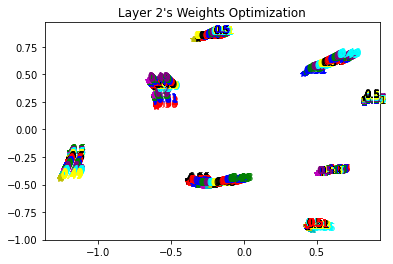

In [10]:
# Plot optimization of Layer 2 of NN
colorList = ['r*', 'b*', 'g*', 'm*', 'c*', 'y*', 'k*']
colorNameList = ["red", "blue", "green", "purple", "cyan", "yellow", 'black']
counter = 0
colorCounter = 0
for pair in layer2Reduced:
    if (counter % 10) == 0 and counter != 0:
        # Change Color
        if colorCounter >= len(colorList) - 1:
            colorCounter = 0
        else:
            colorCounter += 1
    plt.plot(pair[0], pair[1], colorList[colorCounter])
    plt.annotate(str(round(costVector[counter][0], 2)), (pair[0], pair[1]), color=colorNameList[colorCounter])
    counter += 1
plt.title("Layer 2's Weights Optimization") 
plt.show()


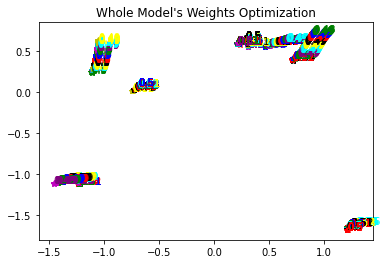

In [11]:
# Plot optimization of Whole Model of NN
counter = 0
colorCounter = 0
for pair in wholeModelReduced:
    if (counter % 10) == 0 and counter != 0:
        if colorCounter >= len(colorList) - 1:
            colorCounter = 0
        else:
            colorCounter += 1
    plt.plot(pair[0], pair[1], colorList[colorCounter])
    plt.annotate(str(round(costVector[counter][0], 2)), (pair[0], pair[1]), color=colorNameList[colorCounter])
    counter += 1
plt.title("Whole Model's Weights Optimization")
plt.show()